

<Body>   
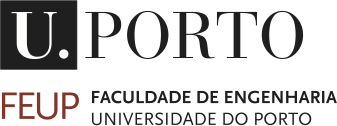   
<h1> <b>VCOMP - Assignment 2  - 2024/2025 </b> </h1>

</Body>  

###António Lopes - up202006725
###Joana Silva - up202006241

Faz no terminal uma vez na primeira vez que correres

pip install torch

pip install torch_snippets

pip install torchvision

pip install scikit-learn

In [172]:
#Import the relevant packages:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch_snippets import *
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import shutil

In [173]:
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cpu device


### Download só no colab aqui ja tem o data set na pasta

### UNZIP

In [174]:
import os
import zipfile

# Get the current working directory (where the script is running)
folder_path = os.getcwd()

# Create a directory to store extracted files
output_folder = os.path.join(folder_path, "extracted_files")
os.makedirs(output_folder, exist_ok=True)

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is a .zip file
    if filename.endswith('.zip'):
        zip_path = os.path.join(folder_path, filename)
        print(f"Processing: {filename}")
        
        # Open and extract the zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract directly into the output folder
            zip_ref.extractall(output_folder)
            print(f"Extracted {filename} into {output_folder}")

print(f"All .zip files in {folder_path} have been processed.")

All .zip files in c:\Users\Utilizador\Documents\GitHub\assign2 have been processed.


### Correct the Dataset

In [175]:
folder_path = os.getcwd()

# Specify the folder path
folder_path = folder_path + "/extracted_files/Kame_CRAS_Pool_2023-09-18" 

# Remove the folder '2023_11_08'
folder_to_remove = os.path.join(folder_path, "2023_11_08")
if os.path.exists(folder_to_remove) and os.path.isdir(folder_to_remove):
    shutil.rmtree(folder_to_remove)
    print(f"Removed folder: {folder_to_remove}")
else:
    print(f"Folder {folder_to_remove} does not exist.")

# Extract contents of '2023_09_18' (or similar) out of its folder
folder_to_extract = os.path.join(folder_path, "2023_09_18")
if os.path.exists(folder_to_extract) and os.path.isdir(folder_to_extract):
    for item in os.listdir(folder_to_extract):
        item_path = os.path.join(folder_to_extract, item)
        target_path = os.path.join(folder_path, item)
        
        # Move files and folders to the main directory
        shutil.move(item_path, target_path)
        print(f"Moved: {item_path} to {target_path}")
    
    # Remove the now-empty folder
    os.rmdir(folder_to_extract)
    print(f"Removed empty folder: {folder_to_extract}")
else:
    print(f"Folder {folder_to_extract} does not exist.")


Folder c:\Users\Utilizador\Documents\GitHub\assign2/extracted_files/Kame_CRAS_Pool_2023-09-18\2023_11_08 does not exist.
Folder c:\Users\Utilizador\Documents\GitHub\assign2/extracted_files/Kame_CRAS_Pool_2023-09-18\2023_09_18 does not exist.


### Show sample images detection of anodes

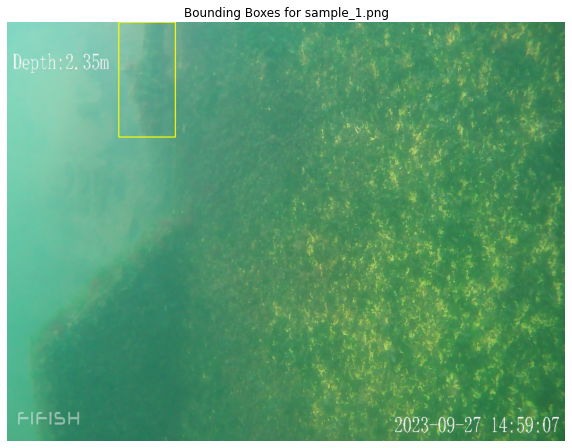

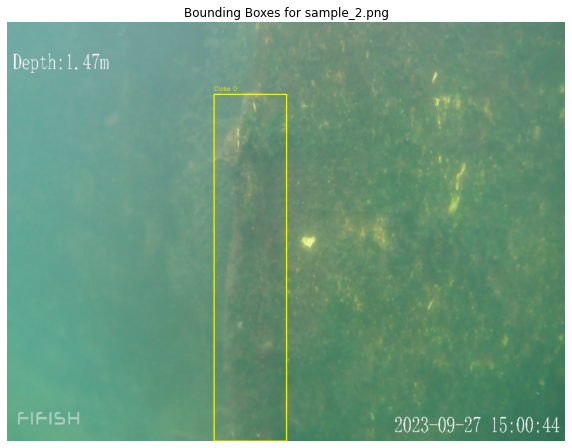

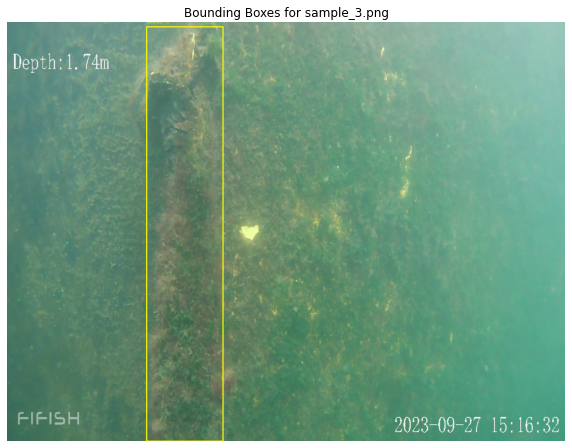

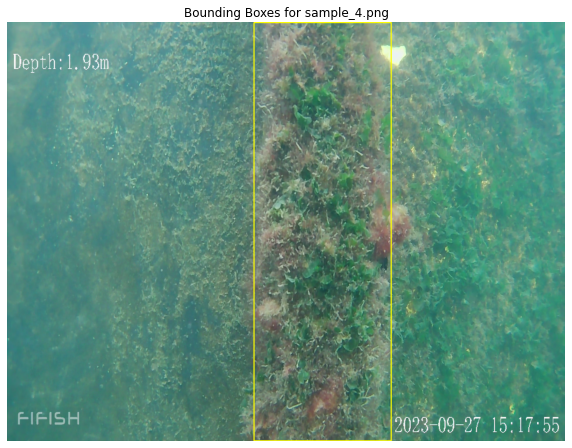

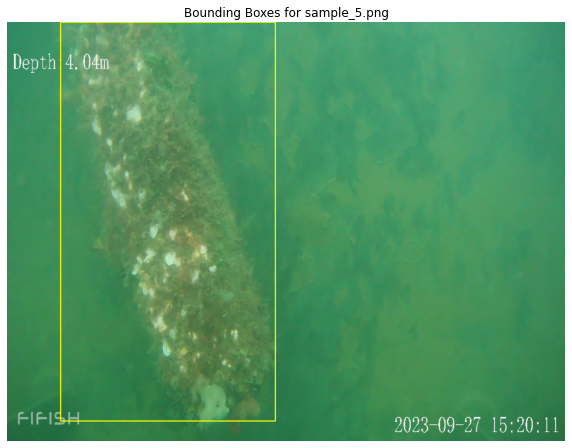

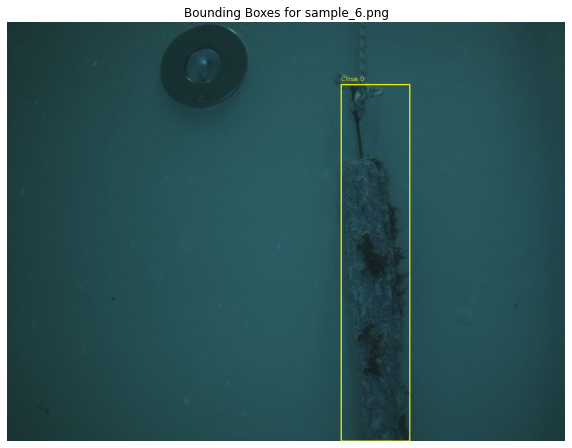

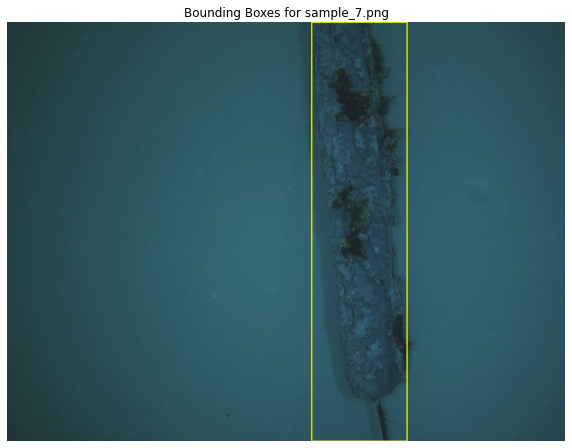

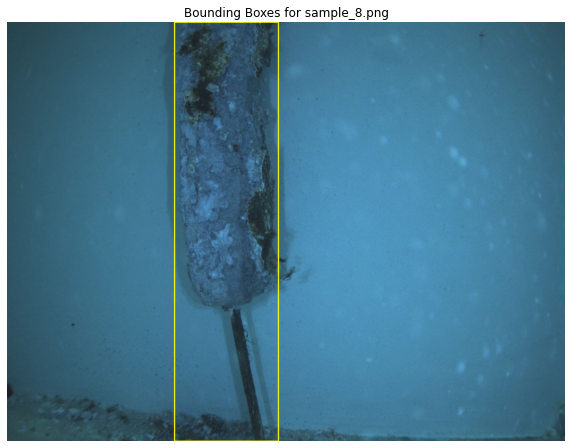

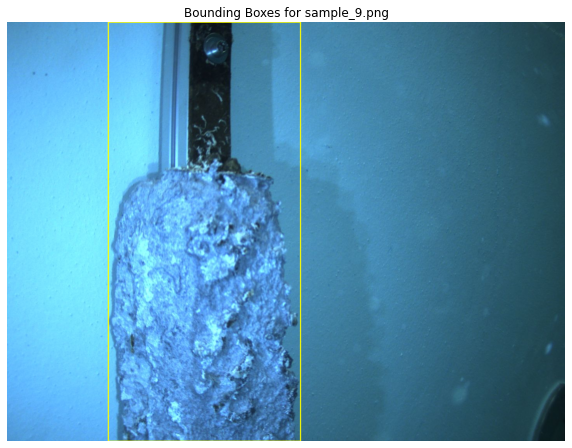

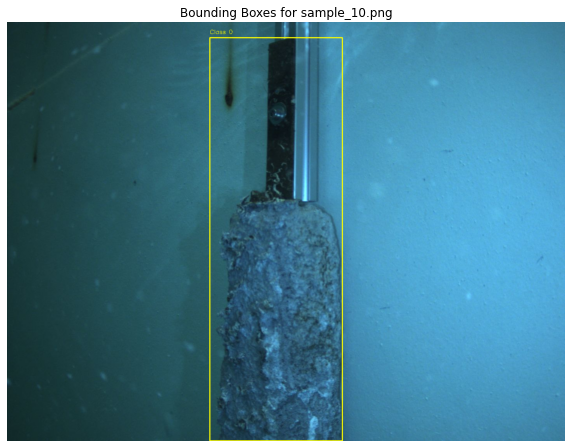

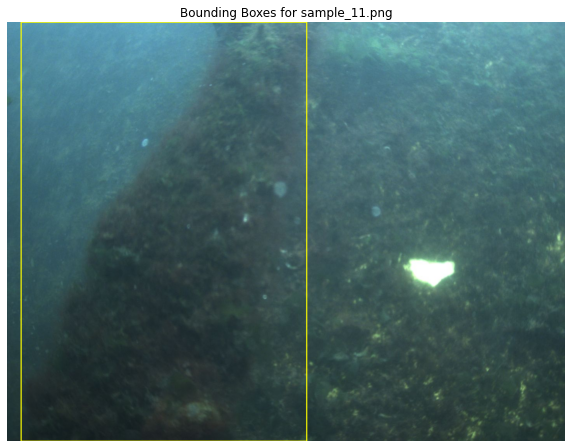

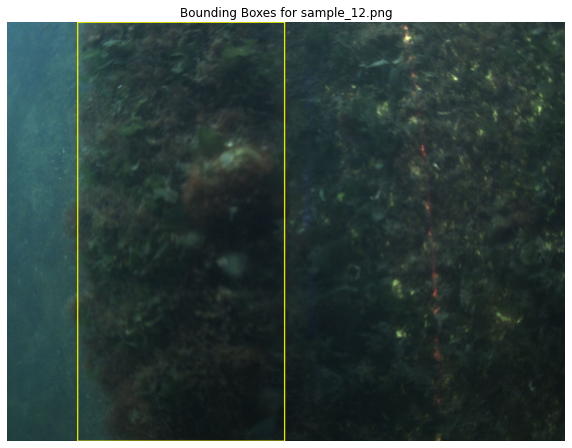

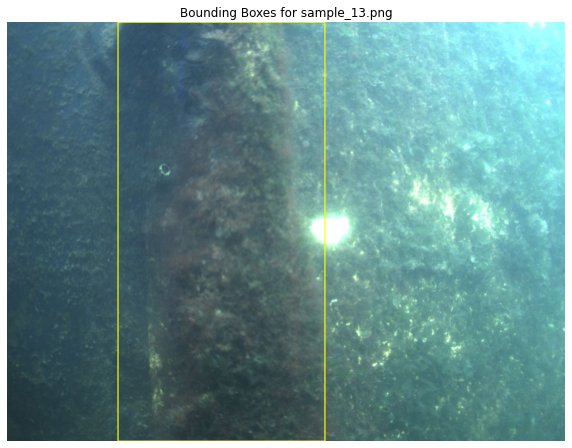

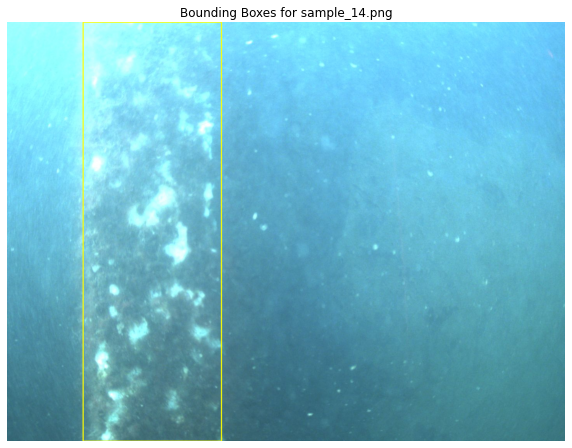

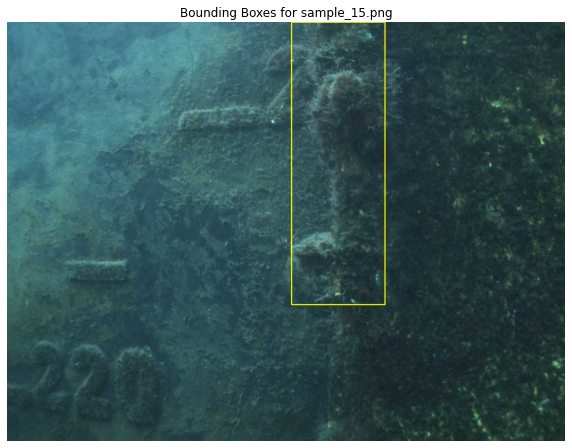

In [176]:
import os
import cv2
import matplotlib.pyplot as plt

# Get the current working directory
folder_path = os.getcwd()

# Specify the path to the Sample folder
sample_folder = os.path.join(folder_path, "extracted_files/Sample")

# Define the paths for images and labels
image_folder = os.path.join(sample_folder, "images")  # Adjust folder name if different
label_folder = os.path.join(sample_folder, "labels")  # Adjust folder name if different

# Helper function to sort files numerically
def numerical_sort(file_list):
    return sorted(file_list, key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Get sorted lists of image and label files
image_files = numerical_sort([f for f in os.listdir(image_folder) if f.startswith("sample_") and f.endswith(".png")])
label_files = numerical_sort([f for f in os.listdir(label_folder) if f.startswith("sample_") and f.endswith(".txt")])

def xywh_to_xyxy(x, y, w, h):
    # Convert normalized values to pixel values
    x_center, y_center, width, height = x, y, w, h
    img_h, img_w, _ = image.shape
    x_center *= img_w
    y_center *= img_h
    width *= img_w
    height *= img_h

    # Calculate bounding box coordinates
    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)

    return x_min, y_min, x_max, y_max               

# Iterate through sorted image and label files
for image_file, label_file in zip(image_files, label_files):
    image_path = os.path.join(image_folder, image_file)
    label_path = os.path.join(label_folder, label_file)
    
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found: {image_path}")
        continue

    # Read the corresponding label file
    with open(label_path, "r") as file:
        for line in file.readlines():
            values = line.split()
            class_id = int(values[0])  # Classification ID

            x_center, y_center, width, height = map(float, values[1:])
            x_min, y_min, x_max, y_max = xywh_to_xyxy(x_center, y_center, width, height)

            # Draw the bounding box
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 255), 2)  # Bounding box in cyan color
            # Add class label
            cv2.putText(image, f"Class {class_id}", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

    # Convert the image from BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"Bounding Boxes for {image_file}")
    plt.show()


### Create the datasets

In [177]:
class PoolDataset(data.Dataset):
    def __init__(self, split, transforms):
        self.transforms = transforms
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.split = split
        self.items = []

        # Populate items with valid image and label pairs
        for image_file in os.listdir(self.image_folder):
            if image_file.endswith(".png"):
                image_path = os.path.join(self.image_folder, image_file)
                label_path = os.path.join(self.label_folder, image_file.replace(".png", ".txt"))
                
                # Check if corresponding label file exists
                if os.path.exists(label_path):
                    self.items.append((image_path, label_path))
                else:
                    print(f"Warning: No label found for image {image_file}")

        print(f"Found {len(self.items)} images in the dataset")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        image_path, label_path = self.items[index]

        # Read the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Initialize labels for classification (0 for background, 1 for anode)
        labels = []
        bbox = []

        # Read the label file for object detection
        with open(label_path, "r") as file:
            for line in file.readlines():
                values = line.split()
                class_id = int(values[0])  # Class ID (0 for background, 1 for anode)

                if class_id == 0:  # No object (background)
                    continue
                
                x_center, y_center, width, height = map(float, values[1:])
                x_min, y_min, x_max, y_max = xywh_to_xyxy(x_center, y_center, width, height)
                
                # Append label and bounding box for detection
                labels.append(class_id)  # Class id of anode (1)
                bbox.append([x_min, y_min, x_max, y_max])  # Bounding box coordinates

        # If no labels (no objects in the image), set it to background
        if len(labels) == 0:
            labels = [0]  # Background class
            bbox = [0, 0, 0, 0]  # Empty bounding box
        
        # Convert to tensors
        labels = torch.tensor(labels, dtype=torch.long)
        bbox = torch.tensor(bbox, dtype=torch.float32)

        # Apply transformations to the image (if any)
        if self.transforms:
            image = self.transforms(image)

        return image, labels, bbox

### Data Augmentation

In [178]:
from torch.utils.data import DataLoader

def get_transforms_no_augmentation():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

def get_transforms_with_augmentation():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.GaussianBlur(kernel_size=(5, 5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

### Create Model

In [179]:
class Network(nn.Module):
    def __init__(self, num_classes=1):  # 1 class (anode)
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3_class = nn.Linear(84, num_classes)  # Output layer for class prediction
        self.fc3_bbox = nn.Linear(84, 4)  # Output layer for bounding box regression

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        class_preds = self.fc3_class(x)  # Class prediction
        bbox_preds = self.fc3_bbox(x)    # Bounding box prediction
        
        return class_preds, bbox_preds

model = Network(num_classes=3)

### Train Model

In [180]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader


# Function to save the model
def saveModel(model: nn.Module, optimizer: Optimizer, path: str):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"Model saved at {path}")

def trainModel(model: nn.Module,
               dataloader: DataLoader,
               loss_function: nn.Module,
               optimizer: Optimizer,
               device: torch.device,
               num_epochs: int,
               path_model: str,
               verbatim=True):
    
    model.train()  # Set the model to training mode
    model.to(device)  # Move model to the correct device
    loss_function.to(device)  # Ensure loss function is on the correct device
    
    best_acc = 0.0
    best_loss = float('inf')  # Initialize to a large value
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()  # Ensure the model is in training mode
        train_correct = 0
        train_loss = 0.0
        total_samples = 0
        
        for ibatch, (images, labels, bbox) in enumerate(dataloader, 0):  # Unpack 3 values
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            bbox = bbox.to(device)  # Ensure bbox is also on the correct device
            
            # 1. Forward pass
            class_preds, bbox_preds = model(images)  # Model outputs both class and bbox predictions
            
            # 2. Calculate loss
            classification_loss = F.cross_entropy(class_preds, labels)
            bbox_loss = F.smooth_l1_loss(bbox_preds, bbox)
            
            # Combine classification and bbox loss
            loss = classification_loss + bbox_loss
            train_loss += loss.item() * images.size(0)  # Accumulate loss
            
            # 3. Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 4. Calculate accuracy
            _, y_pred_class = torch.max(class_preds, dim=1)
            train_correct += (y_pred_class == labels).sum().item()
            total_samples += labels.size(0)
        
        # Calculate average loss and accuracy for the epoch
        avg_loss = train_loss / total_samples
        avg_acc = train_correct / total_samples
        
        # Save the best model based on accuracy
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_loss = avg_loss
            best_epoch = epoch
            saveModel(model, optimizer, path_model)
        
        if verbatim:
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f}")
    
    print(f"Training completed. Best loss: {best_loss:.4f}, Best accuracy: {best_acc:.4f} at epoch {best_epoch+1}")
    
    return best_loss, best_acc, best_epoch

# Evaluation function (for testing the model)
def evaluateModel(model: nn.Module,
                  dataloader: DataLoader,
                  device: torch.device):
    """
    Evaluates the model on a given dataloader.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation during evaluation
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            
            total_loss += loss.item() * images.size(0)  # Accumulate loss
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_acc:.4f}")
    
    return avg_loss, avg_acc

# Load datasets with and without augmentation
train_dataset_no_aug = PoolDataset(split="train", transforms=get_transforms_no_augmentation())
train_dataset_with_aug = PoolDataset(split="train", transforms=get_transforms_with_augmentation())
test_dataset = PoolDataset(split="test", transforms=get_transforms_no_augmentation())  # Test set is not augmented

# Create DataLoaders for each
train_loader_no_aug = DataLoader(train_dataset_no_aug, batch_size=32, shuffle=True)
train_loader_with_aug = DataLoader(train_dataset_with_aug, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define models, loss function, and optimizer
model_no_aug = Network()
model_with_aug = Network()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_no_aug.parameters(), lr=0.001)  # Example optimizer (use same for both models)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model without augmentation
loss_no_aug, acc_no_aug, epoch_no_aug = trainModel(
    model=model_no_aug,
    dataloader=train_loader_no_aug,
    loss_function=loss_function,
    optimizer=optimizer,
    device=device,
    num_epochs=20,  # Number of epochs to train
    path_model="model_no_augmentation.pth"  # Path to save the best model
)

# Train the model with augmentation
loss_with_aug, acc_with_aug, epoch_with_aug = trainModel(
    model=model_with_aug,
    dataloader=train_loader_with_aug,
    loss_function=loss_function,
    optimizer=optimizer,
    device=device,
    num_epochs=20,
    path_model="model_with_augmentation.pth"
)

# Test the model without augmentation
test_loss_no_aug, test_acc_no_aug = evaluateModel(model_no_aug, test_loader, device)
print(f"Test Loss (Without Augmentation): {test_loss_no_aug:.4f}, Test Accuracy (Without Augmentation): {test_acc_no_aug:.4f}")

# Test the model with augmentation
test_loss_with_aug, test_acc_with_aug = evaluateModel(model_with_aug, test_loader, device)
print(f"Test Loss (With Augmentation): {test_loss_with_aug:.4f}, Test Accuracy (With Augmentation): {test_acc_with_aug:.4f}")

Found 15 images in the dataset
Found 15 images in the dataset
Found 15 images in the dataset


RuntimeError: mat1 and mat2 shapes cannot be multiplied (15x44944 and 400x120)

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader

def saveModel(model: nn.Module, optimizer: Optimizer, path: str):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"Model saved at {path}")

def trainModel(model: nn.Module,
               dataloader: DataLoader,
               loss_function: nn.Module,
               optimizer: Optimizer,
               device: torch.device,
               num_epochs: int,
               path_model: str,
               verbatim=True):
    
    model.train()  # Set the model to training mode
    model.to(device)  # Move model to the correct device
    loss_function.to(device)  # Ensure loss function is on the correct device
    
    best_acc = 0.0
    best_loss = float('inf')  # Initialize to a large value
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()  # Ensure the model is in training mode
        train_correct = 0
        train_loss = 0.0
        total_samples = 0
        
        for ibatch, (images, labels) in enumerate(dataloader, 0):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # 1. Forward pass
            outputs = model(images)
            
            # 2. Calculate loss
            loss = loss_function(outputs, labels)
            train_loss += loss.item() * images.size(0)  # Accumulate loss
            
            # 3. Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 4. Calculate accuracy
            _, y_pred_class = torch.max(outputs, dim=1)
            train_correct += (y_pred_class == labels).sum().item()
            total_samples += labels.size(0)
        
        # Calculate average loss and accuracy for the epoch
        avg_loss = train_loss / total_samples
        avg_acc = train_correct / total_samples
        
        # Save the best model based on accuracy
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_loss = avg_loss
            best_epoch = epoch
            saveModel(model, optimizer, path_model)
        
        if verbatim:
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f}")
    
    print(f"Training completed. Best loss: {best_loss:.4f}, Best accuracy: {best_acc:.4f} at epoch {best_epoch+1}")
    
    return best_loss, best_acc, best_epoch


In [181]:
def calculate_iou(pred, ground_truth):
  # coordinates of the area of intersection.
  x1_i = np.maximum(ground_truth[0], pred[0])
  y1_i = np.maximum(ground_truth[1], pred[1])
  x2_i = np.minimum(ground_truth[2], pred[2])
  y2_i = np.minimum(ground_truth[3], pred[3])

  # Intersection height and width.
  intersection_height = np.maximum(y2_i - y1_i + 1, np.array(0.))
  intersection_width = np.maximum(x2_i - x1_i + 1, np.array(0.))

  area_of_intersection = intersection_height * intersection_width

  # Ground Truth dimensions.
  gt_height = ground_truth[3] - ground_truth[1] + 1
  gt_width = ground_truth[2] - ground_truth[0] + 1

  # Prediction dimensions.
  pd_height = pred[3] - pred[1] + 1
  pd_width = pred[2] - pred[0] + 1

  area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection

  # Avoid division by zero
  if area_of_union == 0:
    area_of_union = 1e-6
    print(f"WARNING: Area_of_union = 0!")

  iou = area_of_intersection / area_of_union

  return iou

def calculate_evaluation_metrics(output, label): # precision, recall, iou
    TP = 0
    FP = 0
    FN = 0

    intersection_over_union = 0
    area_pred = 0
    area_ground_truth = 0

    pred = xywh_to_xyxy(output)
    ground_truth = xywh_to_xyxy(label)

    intersection_over_union = calculate_iou(pred, ground_truth)
    area_pred = (pred[2] - pred[0]) * (pred[3] - pred[1])
    area_ground_truth = (ground_truth[2] - ground_truth[0]) * (ground_truth[3] - ground_truth[1])

    TP = intersection_over_union * area_pred
    FP = area_pred - TP
    FN = area_ground_truth - TP

    precision = TP / (TP + FP) # TruePositive / AllObservations
    recall = TP / (TP + FN) # TruePositive / AllGroundTruth

    return precision, recall, intersection_over_union

### Pre-trained Model